In [ ]:
%reset -f

In [ ]:
import argparse
import torch
import os
import scipy
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import random
import shutil
import time
import math
import pdb
from scipy.ndimage import gaussian_filter
dev = 'cuda'
torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)

In [ ]:
Tbin = 32 / (512 * 1.024)  # ns (T2-T1)/N=Tbin from the formulas in the biosensors paper
T0 = 0  # ns
c = 0.29979  # speed of light: m/ns
num_bins = 300 # Number of range bin in interest is 300


# Calculate Range Bins in meters
time_bins = torch.arange(num_bins, dtype=torch.float32)
Rbin_all = c * (Tbin * (time_bins) - T0) / 2 +0.091# Range Bins in meters with starting range bin 0.091
Rbin=Rbin_all[0:num_bins]

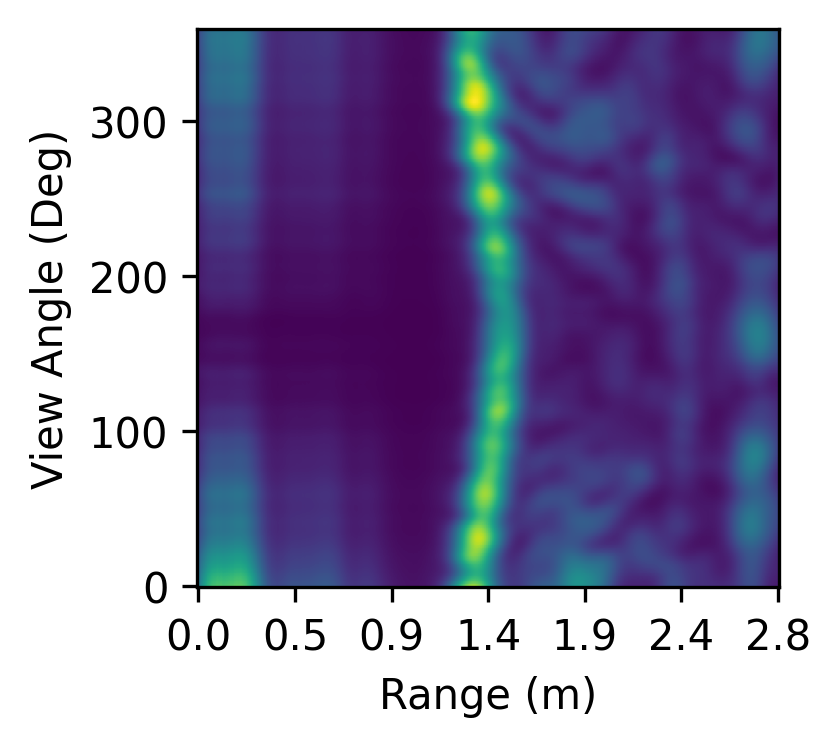

In [ ]:
fft_Rang = num_bins
# Synthetic Radargram Generation
num_scans = 360  # equivalent to 9.20 seconds chosen in parallel with the real data recording with radar sampling freq 68 Hz
num_rbin = fft_Rang  # Specific for setting #4

def safe_normalize(x, eps=1e-4):
    return x / torch.sqrt(torch.clamp(torch.sum(x * x, -1, keepdim=True), min=eps))

file_name='single_can_sinogram.mat'

mat = scipy.io.loadmat(file_name)
data = mat['uwb_sinogram'] # use the key for data here


weights = torch.from_numpy(data).float()
weights = weights[:,0:300]
weights /= weights.max()
fig, ax = plt.subplots(figsize=(2.5, 2.5), dpi=300)
ax.imshow(torch.abs(weights),aspect=0.8, origin='lower')
ax.set_xlabel('Range (m)')
ax.set_ylabel('View Angle (Deg)')

#--------------------------------------------------
x_ticks = np.linspace(0, num_rbin - 1, 7) # 7 ticks
x_tick_labels = np.linspace(0, Rbin[-1], 7)

# Set x-axis ticks and labels
ax.set_xticks(x_ticks)
ax.set_xticklabels([f'{label:.1f}' for label in x_tick_labels])
#--------------------------------------------------

# Set tick font size
ax.tick_params(axis='both', which='both', labelsize=10)

In [ ]:
'''
#------------------------------ Interp 1D ------------------------------
# Courtesy: https://github.com/aliutkus/torchinterp1d/blob/master/torchinterp1d/interp1d.py
'''
import contextlib

class Interp1d(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, y, xnew, out=None):
        """
        Linear 1D interpolation on the GPU for Pytorch.
        This function returns interpolated values of a set of 1-D functions at
        the desired query points `xnew`.
        This function is working similarly to Matlab™ or scipy functions with
        the `linear` interpolation mode on, except that it parallelises over
        any number of desired interpolation problems.
        The code will run on GPU if all the tensors provided are on a cuda
        device.

        Parameters
        ----------
        x : (N, ) or (D, N) Pytorch Tensor
            A 1-D or 2-D tensor of real values.
        y : (N,) or (D, N) Pytorch Tensor
            A 1-D or 2-D tensor of real values. The length of `y` along its
            last dimension must be the same as that of `x`
        xnew : (P,) or (D, P) Pytorch Tensor
            A 1-D or 2-D tensor of real values. `xnew` can only be 1-D if
            _both_ `x` and `y` are 1-D. Otherwise, its length along the first
            dimension must be the same as that of whichever `x` and `y` is 2-D.
        out : Pytorch Tensor, same shape as `xnew`
            Tensor for the output. If None: allocated automatically.

        """
        # making the vectors at least 2D
        is_flat = {}
        require_grad = {}
        v = {}
        device = []
        eps = torch.finfo(y.dtype).eps
        for name, vec in {'x': x, 'y': y, 'xnew': xnew}.items():
            assert len(vec.shape) <= 2, 'interp1d: all inputs must be '\
                                        'at most 2-D.'
            if len(vec.shape) == 1:
                v[name] = vec[None, :]
            else:
                v[name] = vec
            is_flat[name] = v[name].shape[0] == 1
            require_grad[name] = vec.requires_grad
            device = list(set(device + [str(vec.device)]))
        assert len(device) == 1, 'All parameters must be on the same device.'
        device = device[0]

        # Checking for the dimensions
        assert (v['x'].shape[1] == v['y'].shape[1]
                and (
                     v['x'].shape[0] == v['y'].shape[0]
                     or v['x'].shape[0] == 1
                     or v['y'].shape[0] == 1
                    )
                ), ("x and y must have the same number of columns, and either "
                    "the same number of row or one of them having only one "
                    "row.")

        reshaped_xnew = False
        if ((v['x'].shape[0] == 1) and (v['y'].shape[0] == 1)
           and (v['xnew'].shape[0] > 1)):
            # if there is only one row for both x and y, there is no need to
            # loop over the rows of xnew because they will all have to face the
            # same interpolation problem. We should just stack them together to
            # call interp1d and put them back in place afterwards.
            original_xnew_shape = v['xnew'].shape
            v['xnew'] = v['xnew'].contiguous().view(1, -1)
            reshaped_xnew = True

        # identify the dimensions of output and check if the one provided is ok
        D = max(v['x'].shape[0], v['xnew'].shape[0])
        shape_ynew = (D, v['xnew'].shape[-1])
        if out is not None:
            if out.numel() != shape_ynew[0]*shape_ynew[1]:
                # The output provided is of incorrect shape.
                # Going for a new one
                out = None
            else:
                ynew = out.reshape(shape_ynew)
        if out is None:
            ynew = torch.zeros(*shape_ynew, device=device)

        # moving everything to the desired device in case it was not there
        # already (not handling the case things do not fit entirely, user will
        # do it if required.)
        for name in v:
            v[name] = v[name].to(device)

        # calling searchsorted on the x values.
        ind = ynew.long()

        # expanding xnew to match the number of rows of x in case only one xnew is
        # provided
        if v['xnew'].shape[0] == 1:
            v['xnew'] = v['xnew'].expand(v['x'].shape[0], -1)

        # the squeeze is because torch.searchsorted does accept either a nd with
        # matching shapes for x and xnew or a 1d vector for x. Here we would
        # have (1,len) for x sometimes
        torch.searchsorted(v['x'].contiguous().squeeze(),
                           v['xnew'].contiguous(), out=ind)

        # the `-1` is because searchsorted looks for the index where the values
        # must be inserted to preserve order. And we want the index of the
        # preceeding value.
        ind -= 1
        # we clamp the index, because the number of intervals is x.shape-1,
        # and the left neighbour should hence be at most number of intervals
        # -1, i.e. number of columns in x -2
        ind = torch.clamp(ind, 0, v['x'].shape[1] - 1 - 1)

        # helper function to select stuff according to the found indices.
        def sel(name):
            if is_flat[name]:
                return v[name].contiguous().view(-1)[ind]
            return torch.gather(v[name], 1, ind)

        # activating gradient storing for everything now
        enable_grad = False
        saved_inputs = []
        for name in ['x', 'y', 'xnew']:
            if require_grad[name]:
                enable_grad = True
                saved_inputs += [v[name]]
            else:
                saved_inputs += [None, ]
        # assuming x are sorted in the dimension 1, computing the slopes for
        # the segments
        is_flat['slopes'] = is_flat['x']
        # now we have found the indices of the neighbors, we start building the
        # output. Hence, we start also activating gradient tracking
        with torch.enable_grad() if enable_grad else contextlib.suppress():
            v['slopes'] = (
                    (v['y'][:, 1:]-v['y'][:, :-1])
                    /
                    (eps + (v['x'][:, 1:]-v['x'][:, :-1]))
                )

            # now build the linear interpolation
            ynew = sel('y') + sel('slopes')*(
                                    v['xnew'] - sel('x'))

            if reshaped_xnew:
                ynew = ynew.view(original_xnew_shape)

        ctx.save_for_backward(ynew, *saved_inputs)
        return ynew

    @staticmethod
    def backward(ctx, grad_out):
        inputs = ctx.saved_tensors[1:]
        gradients = torch.autograd.grad(
                        ctx.saved_tensors[0],
                        [i for i in inputs if i is not None],
                        grad_out, retain_graph=True)
        result = [None, ] * 5
        pos = 0
        for index in range(len(inputs)):
            if inputs[index] is not None:
                result[index] = gradients[pos]
                pos += 1
        return (*result,)


interp1d = Interp1d.apply

/home/bhanuiit/.local/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


100 of 360
200 of 360
300 of 360
<built-in method numpy of Tensor object at 0x7f809757c400>


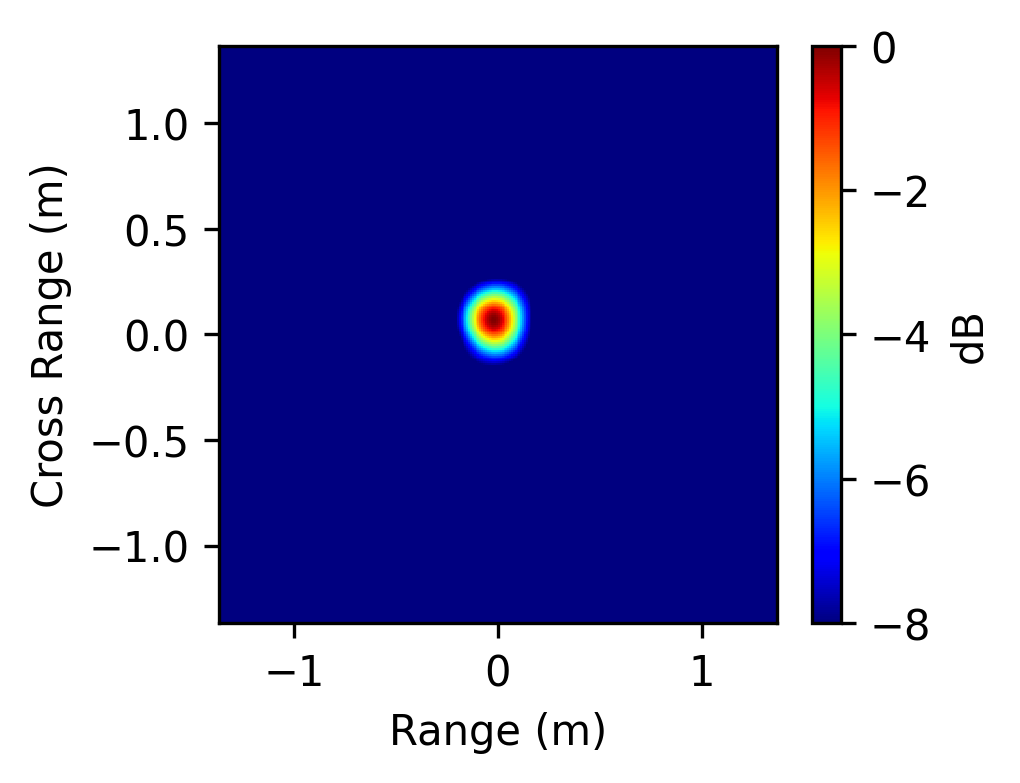

In [ ]:
'''
#------------------------------ Back Projection ------------------------------
'''
num_scans = weights.shape[0]
na = torch.tensor(num_scans)
az = torch.linspace(0,num_scans-1,na)
fft_Rang = Rbin.shape[0] #num_bins

B=2200e6 # 2.2 GHz for P440 UWB Radar
start_frequency = 3.1e9 #
nf = fft_Rang
range_center = torch.tensor(2.0)
x_span = Rbin[-1]-Rbin[0]
y_span = Rbin[-1]-Rbin[0]
nx = fft_Rang
ny = fft_Rang
az_start = 0
az_end = weights.shape[0]-1
window_type = 'None'
dynamic_range = 8
frequency = torch.linspace(start_frequency, start_frequency + B, nf)

sensor_x = range_center * torch.cos(torch.deg2rad(az))
sensor_y = range_center * torch.sin(torch.deg2rad(az))
sensor_z = torch.zeros_like(sensor_x)

xi = torch.linspace(-0.5 * x_span, 0.5 * x_span, nx)
yi = torch.linspace(-0.5 * y_span, 0.5 * y_span, ny)
xii = torch.linspace(-0.5 * x_span, 0.5 * x_span, nx+1)
yii = torch.linspace(-0.5 * y_span, 0.5 * y_span, ny+1)
x_image, y_image = torch.meshgrid(xi, yi)
z_image = torch.zeros_like(x_image)

def backprojection(signal, Rbin, sensor_x, sensor_y, sensor_z, range_center, x_image, y_image, z_image, frequency, fft_length):
    # Speed of light
    c = 299792458

    # Get the frequency step size
    frequency_step = frequency[1] - frequency[0]

    # Calculate the maximum scene size and resolution
    # fs = 9118e3
    # S = 63.343e12
    # range_extent = c * fs / (2.0 * S)
    range_extent = Rbin[-1]-Rbin[0]
    # Calculate the range window for the pulses
    range_window = torch.linspace(-0.5 * range_extent, 0.5 * range_extent, fft_length)

    # Initialize the image
    bp_image = torch.zeros_like(x_image)

    range_center = range_center*torch.ones(len(sensor_x))

    for i in range(len(sensor_x)):
        # Calculate the range profile
        range_profile = signal[i, :]

        # Calculate the range to each pixel
        range_image = torch.sqrt((sensor_x[i] - x_image) ** 2 + (sensor_y[i] - y_image) ** 2
                                 + (sensor_z[i] - z_image) ** 2) - range_center[i]

        # Interpolate the range profile onto the image grid and multiply by the range phase
        # For large scenes, should check the range window and index
        bp_image += interp1d( range_window, range_profile, range_image)

        if (i + 1) % 100 == 0:
            print(f'{i+1} of {len(sensor_x)}')

    return bp_image

fft_length=fft_Rang
bp_image = backprojection(weights.abs(), Rbin, sensor_x, sensor_y, sensor_z, range_center, x_image, y_image, z_image, frequency, fft_length)

bpi = bp_image.abs() / bp_image.abs().max()
print(bp_image.numpy)

# Plot backProjected Image
fig, ax = plt.subplots(figsize=(3, 2.5), dpi=300)
heatmap=ax.pcolormesh(xii, yii, 20.0 * torch.log10(bpi), shading='flat', cmap='jet')
# Set color limits
heatmap.set_clim(-dynamic_range, 0.0)

# Add colorbar
cbar = plt.colorbar(heatmap,label='dB')
ax.set_xlabel('Range (m)')
ax.set_ylabel('Cross Range (m)')

# Set tick font size
ax.tick_params(axis='both', which='both', labelsize=10)

**Generate TX and RX coordinates**

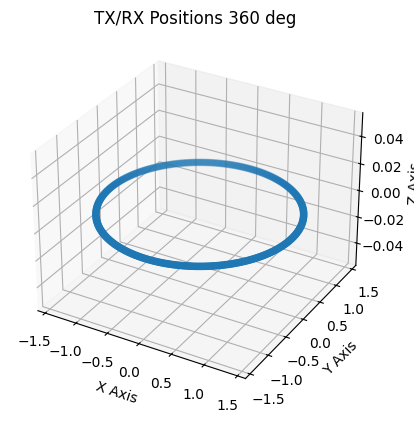

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def apply_rotation_xy_plane(TX, theta):
    v = torch.empty(1, 3)
    center = torch.zeros(1, 3)
    v[:, 0] = TX[0]
    v[:, 1] = TX[1]
    v[:, 2] = TX[2]

    theta_rad = torch.deg2rad(torch.tensor(theta))  # Convert degrees to radians

    Rz = torch.tensor([[torch.cos(theta_rad), -torch.sin(theta_rad), 0],
                       [torch.sin(theta_rad), torch.cos(theta_rad), 0],
                       [0, 0, 1]])

    s = v - center
    so = torch.matmul(s, Rz)
    vo = so + center

    return vo

TX_COORDS_Org = torch.FloatTensor([0+(0.03556/2.0), -Rbin[-1]/2, 0]) # Tx_Position=+(0.03556/2)
RX_COORDS_Org = torch.FloatTensor([0-(0.03556/2.0), -Rbin[-1]/2, 0]) # Rx_Position=-(0.03556/2)

TX_COORDS_Rotated = []
RX_COORDS_Rotated = []

for angle in range(360):
    TX_COORDS_Rotated_temp = apply_rotation_xy_plane(TX_COORDS_Org, -angle)
    TX_COORDS_Rotated.append(TX_COORDS_Rotated_temp)

    RX_COORDS_Rotated_temp = apply_rotation_xy_plane(RX_COORDS_Org, -angle)
    RX_COORDS_Rotated.append(RX_COORDS_Rotated_temp)

# Convert list of tensors to a single tensor
TX_COORDS = torch.cat(TX_COORDS_Rotated, dim=0).to(dev)
RX_COORDS = torch.cat(RX_COORDS_Rotated, dim=0).to(dev)


# Extract x, y, z coordinates for plotting
x_coords = RX_COORDS[:, 0].cpu()
y_coords = RX_COORDS[:, 1].cpu()
z_coords = RX_COORDS[:, 2].cpu()

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x_coords, y_coords, z_coords)

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

plt.title('TX/RX Positions 360 deg')
plt.show()



**Radar Measurements (Complex) using Radar Equations**

In [ ]:
weights.shape

torch.Size([360, 300])

**Network**

In [ ]:
import tinycudann as tcnn
import torch
import torch.nn as nn
import torch.nn.functional as F


def safe_normalize(x, eps=1e-4):
    return x / torch.sqrt(torch.clamp(torch.sum(x * x, -1, keepdim=True), min=eps))

class MLP(torch.nn.Module):
    def __init__(self, dim_in, dim_out, dim_hidden, num_layers):
        super().__init__()
        self.dim_in = dim_in
        self.dim_out = dim_out
        self.dim_hidden = dim_hidden
        self.num_layers = num_layers

        net = []
        for l in range(num_layers):
            # Keep bias false
            x=nn.Linear(self.dim_in if l == 0 else self.dim_hidden,
                                 self.dim_out if l == num_layers - 1 else self.dim_hidden, bias=False)
            # init_weights(x)
            net.append(x)

        self.net = nn.ModuleList(net)

    def forward(self, x):
        for l in range(self.num_layers):
            x = self.net[l](x)
            if l != self.num_layers - 1:
                x = F.relu(x, inplace=True)
        return x

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        # m.bias.data.fill_(0.01)

class Network(torch.nn.Module):

    def __init__(self, dev, num_layers, num_neurons, incoherent=False, real_only=False,
                 scene_voxels=None):
        super().__init__()
        self.dev = dev
        self.no_network = False
        self.scene_voxels = scene_voxels


        if self.scene_voxels is not None:
            assert self.scene_voxels.ndim == 5
            self.scene_voxels.requires_grad_(True)
            self.no_network = True

            self.model = self.no_network_model

        else:
            self.incoherent = incoherent
            self.real_only = real_only

            if self.incoherent or self.real_only:
                self.n_output_dims = 1
            else:
                self.n_output_dims = 2

            self.n_input_dims = 3

            self.encoder = tcnn.Encoding(self.n_input_dims,
                                                            {
                                                                "otype": "HashGrid",
                                                                "n_levels": 14, # default = 14
                                                                "n_features_per_level": 2, # default = 2
                                                                "log2_hashmap_size": 15,#30, default = 15
                                                                "base_resolution": 16, #30 default = 16
                                                                "per_level_scale": 1.5
                                                            })
            self.network = MLP(dim_in=self.encoder.n_output_dims,
                               dim_out=self.n_output_dims,
                               dim_hidden=num_neurons,
                               num_layers=num_layers).float()

            self.model = torch.nn.Sequential(self.encoder, self.network).to(self.dev)

    def model_out(self, x):

        if self.no_network:
            x_input = x[None, None, None, ...]
            out = self.model(x_input)
            out = out.squeeze().view(-1)
            return out
        else:
            out = self.encoder(x)
            out = self.network(out.float())

            if self.incoherent or self.real_only:
                #out = torch.nn.functional.relu(out).float()
                out = out.float()
            else:
                out = torch.complex(real=out[..., 0].float(), imag=out[..., 1].float())

            return out

    def forward(self, coords_to, compute_normals=True):
        with torch.enable_grad():
            # Track gradient for all coordinates

            coords_to.requires_grad_(True)

            coords_to_network = coords_to.reshape(-1, 3)

            output = self.model_out(coords_to_network)

            complex_scatterer_to = output

            if compute_normals:
                normals_out = - torch.autograd.grad(torch.sum(output.abs()),
                                                coords_to_network, create_graph=True)[0]
                normals_out = safe_normalize(normals_out).float()
                normals_out[torch.isnan(normals_out)] = 0

                normals = normals_out
            else:
                normals = None

        return {
            'scatterers_to': complex_scatterer_to,
            'normals': normals
        }

    def normal(self, x):
        with torch.enable_grad():
            x.requires_grad_(True)
            comp_albedo = self.model_out(x)

            normal = - torch.autograd.grad(torch.sum(comp_albedo.abs()), x, create_graph=True)[0]
            normal = safe_normalize(normal).float()
            normal[torch.isnan(normal)] = 0

        return comp_albedo, normal

    def get_params(self, lr):
        if self.no_network:
            return [{'params': self.scene_voxels, 'lr': lr}]
        else:
            return [{'params': self.model.parameters(), 'lr': lr}]


**Spherical Sampling**

In [ ]:
import numpy as np
import torch
# import constants as c
from matplotlib import pyplot as plt
import math
# from render_utils import set_axes_equal, _set_axes_radius
import pdb

class SceneSampler:

    def __init__(self, num_dense_rays, num_sparse_rays, max_distance, device, beamwidth=None):
        self.num_dense_rays = num_dense_rays
        self.num_sparse_rays = num_sparse_rays
        self.max_distance = max_distance
        self.beamwidth = beamwidth
        self.voxel_size = None
        self.max_radius = None
        self.cache_sparse_vectors = None
        self.cache_dense_vectors = None
        self.device = device

        if num_sparse_rays is None and beamwidth is not None:
            # Beampattern radius
            self.max_radius = self.max_distance * math.tan(torch.deg2rad(beamwidth / 2))

            steps = math.ceil(math.sqrt(4 / np.pi) * math.sqrt(num_dense_rays))

            self.voxel_size = (2 * self.max_radius) / steps

            x = torch.linspace(-self.max_radius, self.max_radius, steps=steps)
            y = torch.linspace(-self.max_radius, self.max_radius, steps=steps)
            focal_plane = torch.stack(torch.meshgrid((x, y), indexing='ij')).permute(1, 2, 0)
            focal_plane = torch.cat((focal_plane, torch.zeros(focal_plane.shape[0],
                                                             focal_plane.shape[1], 1) * self.max_distance), dim=-1) # torch.ones
            vectors = focal_plane.reshape(-1, 3)

            indeces = torch.where(vectors[..., 0] ** 2 + vectors[..., 1] ** 2 <= self.max_radius ** 2)[0].long()

            self.cache_dense_vectors = vectors[indeces].to(self.device)

        # Beamwidth is fixed and doing importance sampling, so just cache the sparse rays
        if self.beamwidth is not None and num_sparse_rays is not None:
            # Beampattern radius
            self.max_radius = self.max_distance * math.tan(torch.deg2rad(beamwidth / 2))

            assert int(math.sqrt(num_sparse_rays)) ** 2 == num_sparse_rays

            steps = math.ceil(math.sqrt(4 / np.pi) * math.sqrt(num_sparse_rays))

            self.voxel_size = (2 * self.max_radius) / steps

            x = torch.linspace(-self.max_radius, self.max_radius, steps=steps)
            y = torch.linspace(-self.max_radius, self.max_radius, steps=steps)
            focal_plane = torch.stack(torch.meshgrid((x, y), indexing='ij')).permute(1, 2, 0)
            focal_plane = torch.cat((focal_plane, torch.ones(focal_plane.shape[0],
                                                             focal_plane.shape[1], 1) * self.max_distance), dim=-1)
            vectors = focal_plane.reshape(-1, 3)

            indeces = torch.where(vectors[..., 0] ** 2 + vectors[..., 1] ** 2 <= self.max_radius ** 2)[0].long()

            self.cache_sparse_vectors = vectors[indeces].to(self.device)

    def generate_unit_vectors_within_cone(self,
                                          num_vectors,
                                          beamwidth,
                                          debug_dir=None,
                                          distribution=None,
                                          cache_vectors=False):

        if distribution is not None:
            assert distribution.ndim == 1

            assert self.cache_sparse_vectors is not None, "Need to run spherical_sampling with cache_vectors=True" \
                                                          "before calling with a distribution input argument" \
                                                   "if not using a fixed tx_bw"
            assert self.voxel_size is not None

            indeces = torch.multinomial(distribution.reshape(-1), num_vectors, replacement=True).squeeze()

            vectors = self.cache_sparse_vectors[indeces, :]
            vectors[:, 0:2] = vectors[:, 0:2] + self.voxel_size * (2 * torch.rand_like(vectors[:, 0:2]) - 1)

            vectors = normalize_vectors(vectors)

            if debug_dir is not None:
                pass


            return vectors

        # SPARSE SAMPLING or CONVENTIONAL DENSE SAMPLING #

        # We can just resuse sparse cache vectors for fixed beamwidth
        if cache_vectors and self.beamwidth is not None:
            return self.cache_sparse_vectors

        # Beampattern radius
        self.max_radius = self.max_distance * math.tan(torch.deg2rad(beamwidth / 2))

        # Upsample steps to account for croppping to circle
        steps = math.ceil(math.sqrt(4 / np.pi) * math.sqrt(num_vectors))

        self.voxel_size = (2 * self.max_radius) / steps

        x = torch.linspace(-self.max_radius, self.max_radius , steps=steps)
        y = torch.linspace(-self.max_radius, self.max_radius , steps=steps)
        focal_plane = torch.stack(torch.meshgrid((x, y), indexing='ij')).permute(1, 2, 0)
        focal_plane = torch.cat((focal_plane, torch.ones(focal_plane.shape[0],
                                                         focal_plane.shape[1], 1) * self.max_distance), dim=-1)
        vectors = focal_plane.reshape(-1, 3)

        indeces = torch.where(vectors[..., 0] ** 2 + vectors[..., 1] ** 2 <= self.max_radius** 2)[0].long()

        vectors = normalize_vectors(vectors[indeces])

        if cache_vectors:
            self.cache_sparse_vectors = vectors

        return vectors


    def ellipsoidal_sampling(self, step,radii, tx_pos, rx_pos, num_rays, scene_bounds,
                             tx_vec=None, create_return_vec=False, point_at_center=False,
                             cache_vectors=False,
                             debug_index=None, distribution=None, transmit_from_tx=True, debug_dir=None, #transmit_from_tx= False
                             scene_model=None,
                             transmission_model=None,
                             occlusion_scale=None,
                             compute_normals=True,
                             scene_scale_factor=1,
                             device='cuda'):

        """

        :param radii:
        :param tx_pos:
        :param rx_pos:
        :param scene_bounds:
        :param num_vectors:
        :param tx_bw:
        :param tx_vec:
        :param create_return_vec:
        :param debug:
        :param index:
        :param device:
        :return:
        """

        """
        1. We project rays and do sphere intersections at with TX and RX sitting on the x-axis. Thus, first step is to
        rotate the tx direction vector (which is in world frame) to origin frame.
        2. Project rays from origin and rotate rays to the tx direction vector that we rotated relative to origin
        3. Find the intersection of rays with ellipsoid to radii in the object (there and back)
        4. Rotate sampled points back to world frame using opposite rotation matrix from step 1.
        5. Snap points to PCA world coordainate.
        """
        EPS = 1e-7
        tx_pos = tx_pos.squeeze()
        rx_pos = rx_pos.squeeze()
        if not torch.is_tensor(tx_pos):
            tx_pos = torch.from_numpy(tx_pos).to(device).float()
        if not torch.is_tensor(rx_pos):
            rx_pos = torch.from_numpy(rx_pos).to(device).float()
        if not torch.is_tensor(radii):
            radii = torch.from_numpy(radii).to(device).float()
        if not torch.is_tensor(scene_bounds):
            scene_bounds = torch.from_numpy(scene_bounds).to(device).float()
        if tx_vec is not None and not torch.is_tensor(tx_vec):
            tx_vec = torch.from_numpy(tx_vec).to(device).float().squeeze()

        tx_pos = tx_pos.float()
        rx_pos = rx_pos.float()
        radii = radii.float()
        scene_bounds = scene_bounds.float()

        if tx_vec is not None:
            tx_vec = tx_vec.squeeze().float()

        # phace center of tx and rx
        pca = (tx_pos + rx_pos) / 2
        # tx moved to the origin
        tx_norm = normalize_vectors(tx_pos - pca)

        # distnace between tx and rx
        d = torch.sqrt(torch.sum((tx_pos - rx_pos) ** 2))

        # They will be at the origin initially.
        tx_origin = torch.tensor([d / 2, 0., 0.]).float().to(device)
        rx_origin = torch.tensor([-d / 2, 0., 0.]).float().to(device)

        if tx_vec is None:
            scene_center = torch.mean(scene_bounds, dim=0)
            tx_vec = scene_center - tx_pos
            # Just point torwards scene center and straight ahead (airsas setup)
            if not point_at_center:
                tx_vec[..., 2] = tx_pos[..., 2]
            tx_vec = normalize_vectors(tx_vec)
        else:
            tx_vec = normalize_vectors(tx_vec)

        # Rotation matrix TX to origin
        tx_to_origin = rotation_vec_a_to_vec_b(tx_norm, normalize_vectors(tx_origin))

        if self.beamwidth is None:
            boundary_vecs = normalize_vectors(scene_bounds - tx_pos).float()
            angles = torch.arccos(torch.sum(tx_vec[None, :] * boundary_vecs,
                                            dim=-1).clamp(min=(-1 + EPS), max=(1 - EPS)))
            max_angle = angles.abs().max()
            tx_bw = 2*torch.rad2deg(max_angle)
        else:
            tx_bw = self.beamwidth

        if step > 171:
            # print(tx_vec)
            tx_to_origin=tx_to_origin.to(device)
        # Rotate tx_vec to origin frame
        tx_vec = tx_to_origin @ tx_vec.squeeze()

        # Define the ellipsoid at the origin
        a = radii
        b = radii  #torch.sqrt(a ** 2 - (d ** 2) / 4)
        c = radii  #torch.sqrt(a ** 2 - (d ** 2) / 4)
        #pdb.set_trace()

        # Generate ray direcionts
        # If not using importance sampling then just load the cached dense vectors
        # cache dense vectors only set if num_importance_sample vecs is None
        if distribution is None and self.cache_dense_vectors is not None:
            dir_to = self.cache_dense_vectors
        else:
            dir_to = self.generate_unit_vectors_within_cone(
                                                       num_vectors=num_rays,
                                                       beamwidth=tx_bw,
                                                       cache_vectors=cache_vectors,
                                                       distribution=distribution,
                                                       debug_dir=debug_dir).to(device)
            #pdb.set_trace()
        num_rays = dir_to.shape[0]
        '''
        # rotate vectors to align with tx direction vector (which is in origin frame)
        rot_vecs_to_tx_vec = rotation_vec_a_to_vec_b(torch.tensor([0., 0., 1.]).to(device), tx_vec) # what is this 0 0 1 vector???????
        dir_to = torch.t(rot_vecs_to_tx_vec @ torch.t(dir_to))
        '''
        # Compute distance from rays to sphere intersections. Using positive solution from quadratic formula
        in_fov_index, in_fov_voxels = find_voxels_within_fov(trans_pos=tx_origin.to(device), tx_vec=tx_vec.to(device), origin=scene_center.to(device), voxels=dir_to.to(device), bw=self.beamwidth.to(device), device='cuda')
        if transmit_from_tx:
            dist_to, _ = ray_sphere_intersection(a=a[:, None], b=b[:, None], c=c[:, None], vec_o=tx_origin,
                                                  vec_dir=in_fov_voxels)
            vec_to = tx_origin[None, None, :] + dist_to[..., None]*in_fov_voxels[None, ...] # Equation (15) of the paper
        else:
            dist_to, _ = ray_sphere_intersection(a=a[:, None], b=b[:, None], c=c[:, None],
                                                  vec_o=torch.tensor([0., 0., 0.]).to(a.device),
                                                  vec_dir=in_fov_voxels)
            vec_to = torch.tensor([0., 0., 0.])[None, None, :].to(dist_to.device) + \
                     dist_to[..., None] * in_fov_voxels[None, ...]

        # Rotate vectors to world coordinates
        origin_to_tx = rotation_vec_a_to_vec_b(normalize_vectors(tx_origin), tx_norm)
        vec_to_world = torch.reshape(vec_to, (-1, 3)).float()
        vec_to_world = torch.reshape(torch.t(origin_to_tx @ torch.t(vec_to_world)),
                                     (radii.squeeze().shape[0], in_fov_voxels.shape[0], 3))
        vec_to_world = vec_to_world + pca
        dir_to_world = torch.t(origin_to_tx @ torch.t(in_fov_voxels))


        model_out_info = {}

        if create_return_vec:
            # Find the intersection of vectors back to the receiver with the sampled radii
            # We compute the expected depth of the transmission vectors and then project the rays from the expected
            # depth back torwards the receiver.
            num_rad, num_ray, _ = vec_to_world.shape
            model_out = scene_model(vec_to_world.reshape(-1, 3)*scene_scale_factor, compute_normals=compute_normals)

            scatterers_to = model_out['scatterers_to']
            normals = model_out['normals']

            scatterers_to = scatterers_to.reshape(num_rad, num_ray)

            transmission_probs = transmission_model(radii=radii,
                                                    scatterers_to=scatterers_to.reshape(num_rad, num_ray),
                                                    occlusion_scale=occlusion_scale)

            depth_probs = (scatterers_to.reshape(num_rad, num_ray) * transmission_probs).abs()
            depth_probs = depth_probs / torch.sum(depth_probs, dim=0, keepdim=True)
            # Sort of like expected depth
            # expected_depth_index = torch.argmax(
            #    depth_probs, dim=0)
            expected_depth_index = \
                torch.round(torch.sum(torch.arange(0, num_rad, 1).to(depth_probs.device)[:, None] *
                           depth_probs, dim=0)).long().squeeze()

            # Gather coordinates corresponding to expected depth index
            # Select from row (num_radius) using value specified in each column
            vec_back_orig_x = torch.gather(vec_to[..., 0], 0, expected_depth_index[None, :]).squeeze()
            vec_back_orig_y = torch.gather(vec_to[..., 1], 0, expected_depth_index[None, :]).squeeze()
            vec_back_orig_z = torch.gather(vec_to[..., 2], 0, expected_depth_index[None, :]).squeeze()
            vec_back_orig = torch.cat((vec_back_orig_x[:, None],
                                             vec_back_orig_y[:, None],
                                             vec_back_orig_z[:, None]), dim=-1)


            dir_back = (rx_origin[None, :] - vec_back_orig)
            dir_back = normalize_vectors(dir_back)

            _, dist_back, disc = ray_sphere_intersection(
                                                    a=a[:, None],
                                                    b=b[:, None],
                                                    c=c[:, None],
                                                    vec_o=vec_back_orig,
                                                    vec_dir=dir_back,
                                                    return_disc=True)
            # Only find return paths from the last radius up to the first
            vec_back = vec_back_orig + dist_back[..., None] * dir_back
            vec_back_world = torch.reshape(vec_back, (-1, 3)).float()

            vec_back_world = torch.reshape(torch.t(origin_to_tx @ torch.t(vec_back_world)),
                                     (num_rad, num_rays, 3))
            vec_back_world = vec_back_world + pca

            scatterers_back = scene_model.model_out(vec_back_world.reshape(-1, 3)*scene_scale_factor)

            ignore_return_scatterers_index = (dist_back.reshape(-1) < 0)
            # Set scatterers behind the ray to zero since thy do not affect transmission prob
            scatterers_back[ignore_return_scatterers_index] = \
                scatterers_back[ignore_return_scatterers_index] * 0.

            scatterers_back = scatterers_back.reshape(num_rad, num_ray)

            back_trans_probs = transmission_model(radii=radii,
                                                    scatterers_to=scatterers_back,
                                                    occlusion_scale=occlusion_scale)

            transmission_probs = transmission_probs * back_trans_probs

            model_out_info = {
                'scatterers_to': scatterers_to,
                'transmission_probs': transmission_probs,
                'normals': normals
            }

        return vec_to_world, dir_to_world, model_out_info

def normalize_vectors(vec):
    return vec / torch.sqrt(torch.sum(vec**2, dim=-1))[..., None]


# https://math.stackexchange.com/questions/180418/calculate-rotation-matrix-to-align-vector-a-to-vector-b-in-3d
# rotation matrix to rotate vector a onto vector b
def rotation_vec_a_to_vec_b(vec_a, vec_b):
    vec_a = vec_a.squeeze()
    vec_b = vec_b.squeeze()

    assert vec_a.ndim == 1
    assert vec_b.ndim == 1


    v = torch.cross(vec_a, vec_b)
    #print("v", v)
    c = torch.dot(vec_a, vec_b)
    #print("c", c)
    v_x = skew_symm_cp(v)
    #print("v_x", v_x)

    # handle anti-parallel vector case
    if (1 + c).item() < 1e-2:
        #print("SATISFIED")
        return -torch.eye(3).to(vec_a.device)

    return torch.eye(3).to(vec_a.device) + v_x + (v_x @ v_x) * (1 / (1 + c))


def ray_sphere_intersection(a, b, c, vec_o, vec_dir, return_disc=False):
    if vec_o.ndim == 1:
        vec_o = vec_o[None, ...]

    alpha = \
        (vec_dir[..., 0]**2)/(a**2) + \
        (vec_dir[..., 1]**2)/(b**2)

    beta = \
        (2*vec_o[..., 0]*vec_dir[..., 0])/(a**2) + \
        (2*vec_o[..., 1]*vec_dir[..., 1])/(b**2)

    kappa = \
        (vec_o[..., 0]**2)/(a**2) + \
        (vec_o[..., 1]**2)/(b**2) - 1.

    disc = beta**2 - 4*alpha*kappa

    #assert (disc >= 0).all()

    t_pos = (-beta + torch.sqrt(disc))/(2*alpha)
    t_neg = (-beta - torch.sqrt(disc))/(2*alpha)

    if return_disc:
        return t_pos, t_neg, disc
    else:
        return t_pos, t_neg


def skew_symm_cp(x):
    assert len(x) == 3
    assert x.ndim == 1

    if not torch.is_tensor(x):
        return np.array([[0, -x[2], x[1]],
                     [x[2], 0, -x[0]],
                     [-x[1], x[0], 0]])
    else:
        return torch.tensor([[0., -x[2], x[1]],
                        [x[2], 0., -x[0]],
                        [-x[1], x[0], 0.]]).to(x.device).float()


def find_voxels_within_fov(trans_pos, tx_vec, origin, voxels, bw, device='cuda'):
    assert trans_pos.ndim == 1

    orig_numpy = False

    if not torch.is_tensor(trans_pos):
        orig_numpy = True
        trans_pos = torch.from_numpy(trans_pos)

    if not torch.is_tensor(tx_vec):
        tx_vec = torch.from_numpy(tx_vec)

    if not torch.is_tensor(origin):
        origin = torch.from_numpy(origin)

    if not torch.is_tensor(voxels):
        voxels = torch.from_numpy(voxels)

    trans_pos = trans_pos.to(device).float()
    tx_vec = tx_vec.to(device).float()
    origin = origin.to(device).float()
    voxels = voxels.to(device).float()

    # rotate the voxels to the origin
    rot_mat = rotation_vec_a_to_vec_b(tx_vec, origin.type(tx_vec.dtype))
    shift_voxels = voxels - trans_pos[None, ...]
    origin_voxels = (rot_mat @ shift_voxels.T).T

    origin_voxels_normalized = torch.nn.functional.normalize(origin_voxels, p=2, dim=1)

    dot_products = torch.matmul(origin_voxels_normalized, tx_vec)



    # Find points within the specified beamwidth
    in_fov_index = dot_products >= torch.cos(torch.deg2rad(bw / 2))
    in_fov_voxels = voxels[in_fov_index]

    return in_fov_index,in_fov_voxels



**FORWARD MODEL**

In [ ]:
import torch
# from sas_utils import safe_normalize

def cumprod_exclusive(
        tensor: torch.Tensor
) -> torch.Tensor:
    r"""
    (Courtesy of https://github.com/krrish94/nerf-pytorch)
    Mimick functionality of tf.math.cumprod(..., exclusive=True), as it isn't available in PyTorch.
    Args:
    tensor (torch.Tensor): Tensor whose cumprod (cumulative product, see `torch.cumprod`) along dim=-1
      is to be computed.
    Returns:
    cumprod (torch.Tensor): cumprod of Tensor along dim=-1, mimiciking the functionality of
      tf.math.cumprod(..., exclusive=True) (see `tf.math.cumprod` for details).
    """

    # Compute regular cumprod first (this is equivalent to `tf.math.cumprod(..., exclusive=False)`).
    cumprod = torch.cumprod(tensor, -1)
    # "Roll" the elements along dimension 'dim' by 1 element.
    cumprod = torch.roll(cumprod, 1, -1)
    # Replace the first element by "1" as this is what tf.cumprod(..., exclusive=True) does.
    cumprod[..., 0] = 1.

    return cumprod

def scattering_model(scatterers, normals, dir_vec, ratio=0.):
    assert dir_vec.shape[0] == normals.shape[1]
    # Normals is shape [num_r, num_vec, 3]
    # dir_vec is shape [num_vec, 3]

    lambertian = ratio + (1 - ratio) * torch.sum((normals*dir_vec[None, ...]), dim=-1).clamp(min=0)

    scatterers_lamb = scatterers * lambertian

    return scatterers_lamb

def transmission_model(radii, scatterers_to, occlusion_scale, factor2=False):
    radii_to = radii[1:] - radii[:-1]
    radii_to = torch.cat((radii_to, torch.tensor([torch.mean(radii_to)]).to(radii.device)), dim=-1)
    # normalize scatterer magnitude within 0 and 1

    # If we are assuming tranmission ray is the same as receive ray
    if factor2:
        occlusion_scale = occlusion_scale * 2

    alpha = torch.exp(-(scatterers_to.abs() * radii_to[:, None] * occlusion_scale))
    trans_prob = cumprod_exclusive((alpha + 1e-10).permute(1, 0)).permute(1, 0)

    return trans_prob


In [ ]:
scene_model = Network(dev= 'cuda', num_layers=4, # default = 3
                              num_neurons=128, # default = 128
                              scene_voxels=None,
                              incoherent=False,
                              real_only=False)

scene_optimizer = torch.optim.Adam(scene_model.get_params(0.001), lr=0.001)

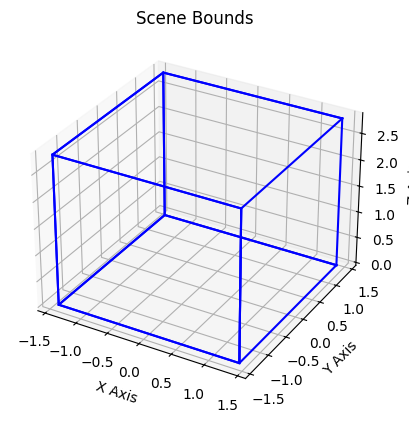

In [ ]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

side_length = Rbin[-1]#-Rbin[0]#Rbin1[-1]#==================================================
half_side = side_length / 2

# Coordinates of the corners of the cube
corners = torch.tensor([
    [half_side, half_side, side_length],
    [-half_side, half_side, side_length],
    [-half_side, -half_side, side_length],
    [half_side, -half_side, side_length],
    [half_side, half_side, 0],
    [-half_side, half_side, 0],
    [-half_side, -half_side, 0],
    [half_side, -half_side, 0]
])

# Define the edges of the cube
edges = [
    [corners[0], corners[1], corners[2], corners[3]],
    [corners[4], corners[5], corners[6], corners[7]],
    [corners[0], corners[1], corners[5], corners[4]],
    [corners[2], corners[3], corners[7], corners[6]],
    [corners[1], corners[2], corners[6], corners[5]],
    [corners[0], corners[3], corners[7], corners[4]],
    [corners[0], corners[4]],
    [corners[1], corners[5]],
    [corners[2], corners[6]],
    [corners[3], corners[7]]
]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting the edges
for edge in edges:
    edge = torch.stack(edge)
    x, y, z = edge[:, 0], edge[:, 1], edge[:, 2]
    ax.plot(x, y, z, color='b')

# Plot settings
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

plt.title('Scene Bounds')
plt.show()


In [ ]:
corners

tensor([[ 1.4133,  1.4133,  2.8265],
        [-1.4133,  1.4133,  2.8265],
        [-1.4133, -1.4133,  2.8265],
        [ 1.4133, -1.4133,  2.8265],
        [ 1.4133,  1.4133,  0.0000],
        [-1.4133,  1.4133,  0.0000],
        [-1.4133, -1.4133,  0.0000],
        [ 1.4133, -1.4133,  0.0000]])

In [ ]:
# Define the boundaries
x_min, y_min, z_min = corners[:, 0].min(), corners[:, 1].min(), corners[:, 2].min()
x_max, y_max, z_max = corners[:, 0].max(), corners[:, 1].max(), corners[:, 2].max()

NUM_X, NUM_Y, NUM_Z = Rbin.shape[0],Rbin.shape[0],1#num_bins, num_bins, 1

# Generating voxel coordinates
x_coords = torch.linspace(x_min, x_max, NUM_X)
y_coords = torch.linspace(y_min, y_max, NUM_Y)
z_coords = torch.linspace(z_min, z_max, NUM_Z)

# Creating mesh grid
X, Y, Z = torch.meshgrid(x_coords, y_coords, z_coords)

# Reshaping to obtain voxel coordinates
all_scene_coords = torch.stack((X.flatten(), Y.flatten(), Z.flatten()), dim=1)

print(x_coords.shape)
print(all_scene_coords)  # Check the shape of the voxel coordinates


torch.Size([300])
tensor([[-1.4133, -1.4133,  0.0000],
        [-1.4133, -1.4038,  0.0000],
        [-1.4133, -1.3943,  0.0000],
        ...,
        [ 1.4133,  1.3943,  0.0000],
        [ 1.4133,  1.4038,  0.0000],
        [ 1.4133,  1.4133,  0.0000]])


In [ ]:
# Calculate the corners or bounding coordinates
x_min, x_max = torch.min(x_coords), torch.max(x_coords)
y_min, y_max = torch.min(y_coords), torch.max(y_coords)
z_min, z_max = torch.min(z_coords), torch.max(z_coords)

# Create tensors for corners
x_corners = torch.tensor([x_min, x_max])
y_corners = torch.tensor([y_min, y_max])
z_corners = torch.tensor([z_min, z_max])

# Combine into corners tensor
corners = torch.stack([
    torch.stack([x_corners[0], y_corners[0], z_corners[0]]),
    torch.stack([x_corners[1], y_corners[0], z_corners[0]]),
    torch.stack([x_corners[0], y_corners[1], z_corners[0]]),
    torch.stack([x_corners[1], y_corners[1], z_corners[0]]),
    torch.stack([x_corners[0], y_corners[0], z_corners[1]]),
    torch.stack([x_corners[1], y_corners[0], z_corners[1]]),
    torch.stack([x_corners[0], y_corners[1], z_corners[1]]),
    torch.stack([x_corners[1], y_corners[1], z_corners[1]])
]).to(dev)

In [ ]:
corners

tensor([[-1.4133, -1.4133,  0.0000],
        [ 1.4133, -1.4133,  0.0000],
        [-1.4133,  1.4133,  0.0000],
        [ 1.4133,  1.4133,  0.0000],
        [-1.4133, -1.4133,  0.0000],
        [ 1.4133, -1.4133,  0.0000],
        [-1.4133,  1.4133,  0.0000],
        [ 1.4133,  1.4133,  0.0000]], device='cuda:0')

(4) Main train loop

In [ ]:
num_rays = 3500
sampling_distribution_uniformity=1 # args
# distribution = np.abs(weights)**(sampling_distribution_uniformity/1) / \
                        # np.sum(np.abs(weights)**(sampling_distribution_uniformity/1), axis=-1)[..., None]

# Create Sampler
# If beamwidth is not none, then this will compute the sparse rays.
scene_sampler = SceneSampler(num_dense_rays=num_rays, # default = 1000
                                 num_sparse_rays=None,
                                 max_distance=Rbin[-1]-Rbin[0],#3.5950, #meters 3.5/2
                                 beamwidth=torch.tensor([90.]), # None
                                 device=dev)

compute_normals = True
sequential_sample=1
scale_factor = 1
tx_vec = None
sampling_distribution=None
debug_dir = None
ray_trace_return = False
point_at_center = False
transmit_from_tx = True # Default: false
occlusion_scale = 1
scene_scale_factor = torch.tensor(1.00, dtype=torch.float64)#1.2500

start = 1
global_step = start
dists_scene_cropped = Rbin.to(dev) #<==================================
num_epochs = 10

###################################
# (4) Main train loop
###################################
est=[]
while global_step<weights.shape[0]+1:
  for epoch in range(0, num_epochs): #start,num_epochss
    if sequential_sample:
      rand_batch = global_step % weights.shape[0]
    else:
      rand_batch = random.sample(range(weights.shape[0]), 1)

    index_batch = torch.arange(0, weights.shape[1]) #384 num_rbin
    weight_batch = weights[rand_batch-1].squeeze()

    # GROUND TRUTH MEASUREMENT
    gt_weight_cropped = weight_batch[index_batch] * scale_factor

    # GT TX RX Pos
    tx_batch = TX_COORDS[rand_batch-1]
    rx_batch = RX_COORDS[rand_batch-1]


    vec_to, dir_to, model_out = scene_sampler.ellipsoidal_sampling(
                step = global_step,
                radii=(dists_scene_cropped).to(dev), #<======= default: no /2
                tx_pos=tx_batch.to(dev),
                rx_pos=rx_batch.to(dev),
                num_rays=num_rays,
                scene_bounds=corners,
                tx_vec=tx_vec,
                create_return_vec=ray_trace_return,
                point_at_center=point_at_center,
                distribution=sampling_distribution,
                debug_dir=debug_dir,
                transmit_from_tx=transmit_from_tx,
                scene_model=scene_model,
                transmission_model=transmission_model,
                occlusion_scale=occlusion_scale,
                compute_normals=compute_normals,
                scene_scale_factor=scene_scale_factor)

    num_to_rad, num_to_rays, _ = vec_to.shape

    ######################
    # (4.2) Forward model
    #######################

    lambertian_ratio = 1
    model_out = scene_model(coords_to=vec_to,#vec_to.shape->[326, 9845, 3]
                            compute_normals=compute_normals)

    scatterers_to = model_out['scatterers_to'] #[326, 9845] Complex
    normals = model_out['normals']#[326, 9845, 3]

    scatterers_to = scatterers_to.reshape(num_to_rad, num_to_rays)
    if compute_normals:
        normals = normals.reshape(num_to_rad, num_to_rays, 3)

    transmission_probs = transmission_model(radii=dists_scene_cropped,#radii=dists_scene_cropped[:len(dists_scene_cropped)//2], #
                                            scatterers_to=scatterers_to,
                                            occlusion_scale=occlusion_scale,
                                            factor2=True)

    # We only integrate the to vectors (since they are definitely within TX beamwidth.)
    if normals is not None:
        # Add lambertian scattering
        scatterers_lamb = scattering_model(
            scatterers=scatterers_to,
            normals=normals,
            dir_vec=-dir_to,
            ratio=lambertian_ratio)
    else:
        scatterers_lamb = scatterers_to

    scatterers_to_integrate = scatterers_lamb * transmission_probs # [326, 9845]

    # Integrate rays along ellipsoid
    estimated_weights = torch.sum(scatterers_to_integrate, dim=-1).to(dev)#F.normalize(torch.sum(scatterers_to_integrate, dim=-1).to(dev),dim=0)# 326
    gt_weight_cropped = gt_weight_cropped.to(dev)#F.normalize(gt_weight_cropped.to(dev),dim = 0)#gt_weight_cropped.to(dev)#





    # Calculate Loss
    # weight_loss = torch.nn.functional.mse_loss(estimated_weights.abs().float().squeeze(),gt_weight_cropped.abs().float().squeeze(), reduction='mean')#+torch.nn.functional.mse_loss(estimated_weights.imag.float().squeeze(),gt_weight_cropped.imag.float().squeeze(), reduction='mean')
    weight_loss = torch.nn.functional.mse_loss(estimated_weights.abs().float().squeeze(),gt_weight_cropped.abs().float().squeeze(), reduction='mean')#+torch.nn.functional.mse_loss(estimated_weights.imag.float().squeeze(),gt_weight_cropped.imag.float().squeeze(), reduction='mean')
    total_loss = weight_loss
    # Back propagate
    total_loss.backward()
    scene_optimizer.step()
    scene_optimizer.zero_grad()
    if (epoch) % 1 == 0:
      print(f'Global Step [{global_step}/{360}], Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss.item():.5f}')
  est.append(estimated_weights.abs().cpu().detach())
  global_step =global_step + 1


Global Step [1/360], Epoch [1/10], Loss: 0.12953
Global Step [1/360], Epoch [2/10], Loss: 0.06051
Global Step [1/360], Epoch [3/10], Loss: 0.05749
Global Step [1/360], Epoch [4/10], Loss: 0.02829
Global Step [1/360], Epoch [5/10], Loss: 0.01211
Global Step [1/360], Epoch [6/10], Loss: 0.00776
Global Step [1/360], Epoch [7/10], Loss: 0.00529
Global Step [1/360], Epoch [8/10], Loss: 0.00597
Global Step [1/360], Epoch [9/10], Loss: 0.00456
Global Step [1/360], Epoch [10/10], Loss: 0.00199
Global Step [2/360], Epoch [1/10], Loss: 0.00214
Global Step [2/360], Epoch [2/10], Loss: 0.00139
Global Step [2/360], Epoch [3/10], Loss: 0.00162
Global Step [2/360], Epoch [4/10], Loss: 0.00133
Global Step [2/360], Epoch [5/10], Loss: 0.00086
Global Step [2/360], Epoch [6/10], Loss: 0.00112
Global Step [2/360], Epoch [7/10], Loss: 0.00071
Global Step [2/360], Epoch [8/10], Loss: 0.00054
Global Step [2/360], Epoch [9/10], Loss: 0.00048
Global Step [2/360], Epoch [10/10], Loss: 0.00029
Global Step [3/360

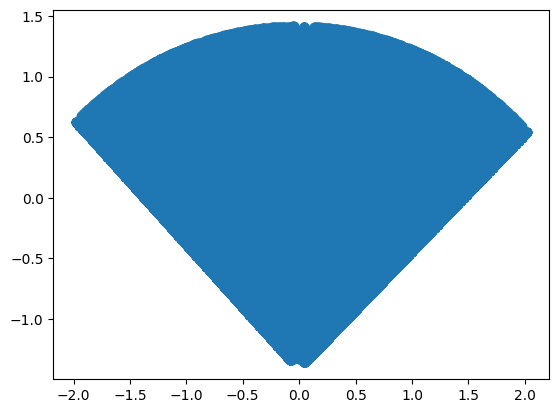

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(vec_to[...,0].detach().cpu().numpy(),
    vec_to[...,1].detach().cpu().numpy())

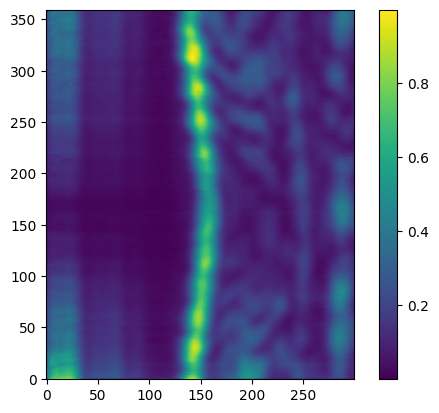

In [ ]:
est1=torch.stack(est)
est1.shape
plt.imshow(est1.numpy(), origin='lower')
plt.colorbar()
plt.show()

In [ ]:
# gt_weight_cropped

In [ ]:
# torch.sum(scatterers_to_integrate, dim=-1).abs()

In [ ]:
model_out = scene_model(coords_to=all_scene_coords.to('cuda'),compute_normals=compute_normals)
comp_albedo = model_out['scatterers_to']

In [ ]:
def matplotlib_render_2d(mag, thresh, x_voxels, y_voxels, z_voxels, x_corners, y_corners, z_corners):
    mag = gaussian_filter(np.abs(mag), sigma=7)#np.abs(mag)
    mag = mag.ravel()
    mag=(20*np.log10(mag/np.max(mag)))

    # u = mag.mean()
    # var = mag.std()
    # mag[mag[:] < (u + thresh * var)] = None

    fig, ax = plt.subplots(figsize=(3, 2.5), dpi=300)

    ax.clear()
    im = ax.scatter(x_voxels,
                    y_voxels,
                    # z_voxels,
                    c=mag, alpha=0.5, cmap='jet')


    # Set color limits
    im.set_clim(-dynamic_range, 0.0)

    # Add colorbar
    cbar = plt.colorbar(im,label='dB')
    ax.set_xlabel('Range (m)')
    ax.set_ylabel('Cross Range (m)')

    # Set tick font size
    ax.tick_params(axis='both', which='both', labelsize=10)

    ax.set_xlim(
        (x_corners.min(), x_corners.max()))
    ax.set_ylim(
        (y_corners.min(), y_corners.max()))

    # plt.grid(True)


    # fig.savefig(save_path)
    # plt.close(fig)
    return fig

In [ ]:
x_then_y = True
plot_thresh = 3.51/2.0
if x_then_y:
    comp_albedo = comp_albedo.reshape(NUM_X, NUM_Y,NUM_Z).detach().cpu().numpy()
else:
    comp_albedo = comp_albedo.reshape(NUM_Y, NUM_X, NUM_Z).detach().cpu().numpy()



In [ ]:
comp_albedo.shape

(300, 300, 1)

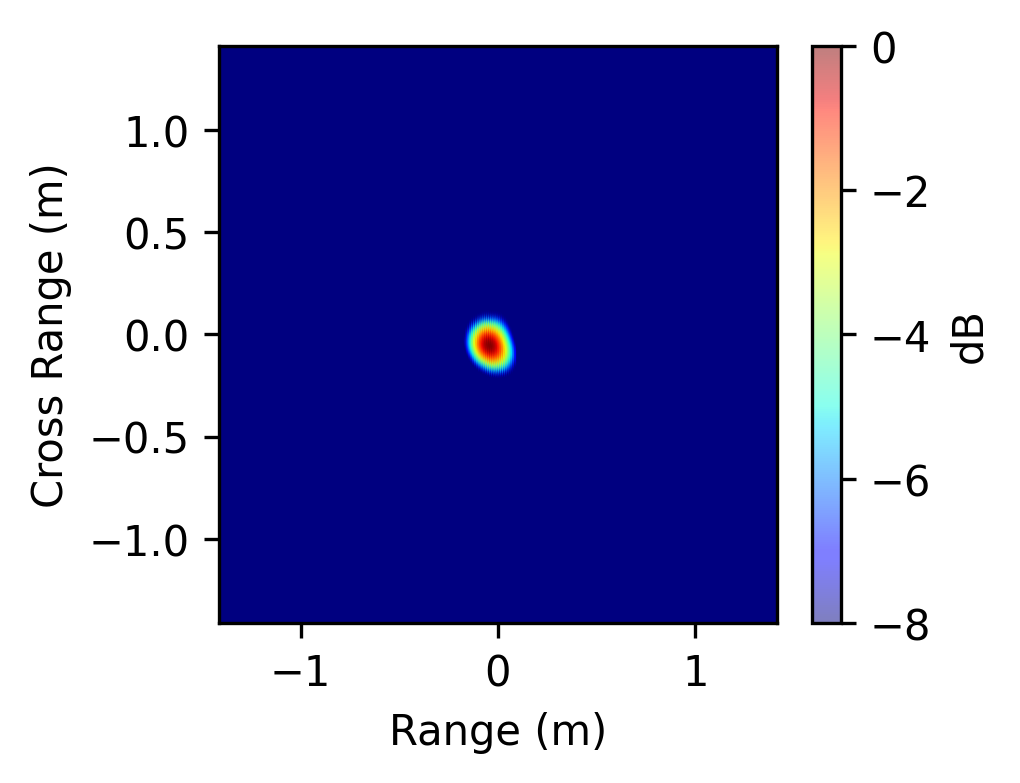

In [ ]:
fig = matplotlib_render_2d(np.abs(comp_albedo), plot_thresh,
                                    x_voxels=all_scene_coords[:, 0].detach().numpy(),
                                    y_voxels=all_scene_coords[:, 1].detach().numpy(),
                                    z_voxels=all_scene_coords[:, 2].detach().numpy(),
                                    x_corners=all_scene_coords[:, 0].detach().numpy(),
                                    y_corners=all_scene_coords[:, 1].detach().numpy(),
                                    z_corners=all_scene_coords[:, 2].detach().numpy())

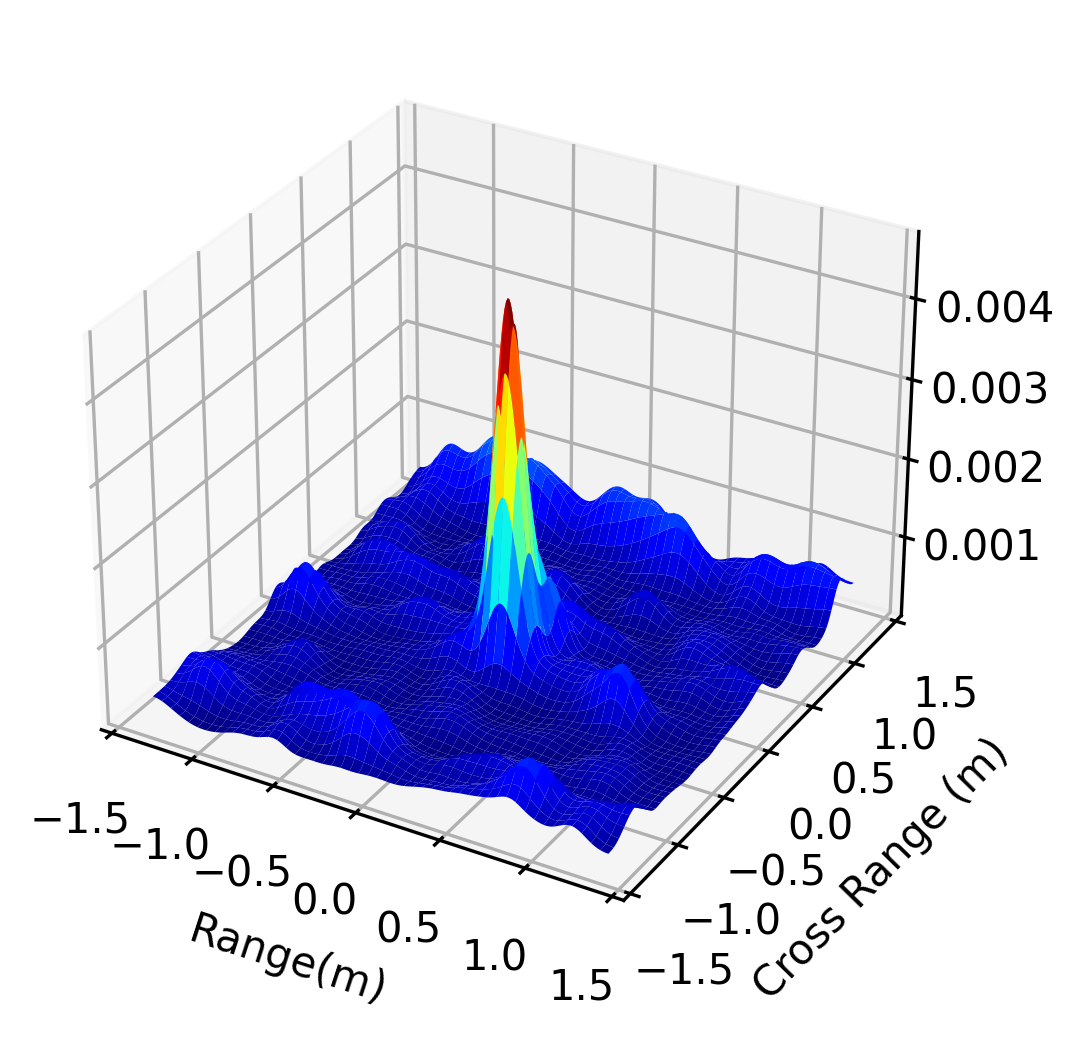

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D


# Assuming 'data' is your NumPy array
data1 = np.abs(comp_albedo.squeeze())
data = gaussian_filter(data1, sigma=7)
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
fig = plt.figure(figsize=(4, 4.5), dpi=300)

# Add a 3D subplot
ax = fig.add_subplot(111, projection='3d')

# x = np.arange(0, num_bins)
# y = np.arange(0, num_bins)
X, Y = np.meshgrid(xi, yi)
Z = data

ax.plot_surface(Y, X, Z,cmap='jet') #,cmap='viridis')

ax.set_xlabel('Range(m)')
ax.set_ylabel('Cross Range (m)')
ax.tick_params(axis='both', which='both', labelsize=10)
# ax.set_zlabel('Z axis')


plt.show()